<img src="https://s3.amazonaws.com/datascienceheroes.com/EDV/360_banner_python.png" width="400px">


# Escuela de Datos Vivos 

## LAB P.C.2: Análisis de correlación
Creado por Pablo Casas | https://escueladedatosvivos.ai   

Resuelto por Pablo Sotomayor

## Ejercicios

1) Cargar los datos de 'data/hotels_smp.csv' (fuente: [tidytuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md))

2) ¿Cuales son el top 5 de variables que mas se correlacionan con la variable `is_canceled` (var a predecir)? 

2.a) Medir la correlación usando Pearson, y luego MIC.

2.b) Graficar ambos conjuntos de variables

3) Si hay variables categóricas, discretizarlas con get_dummies, pero sacar una de cada conjunto de variables para evitarr la auto-correlación (el efecto que mencionamos anteriormente)

4) Crear una pequeña lógica que grafique, para una lista de variables dada (puede ser la del punto 2), la variable a predecir en función de las variables numéricas.

5) Crear un breve resumen de los insights que se encuentren al analizar el top N de variables mas importantes. 

## Solución

In [1]:
# Cargamos las librerías que utilizaremos en este proyecto

import itertools
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from minepy import MINE
from pandas_profiling import ProfileReport
from funpymodeling.exploratory import status, freq_tbl, profiling_num, cat_vars, num_vars, corr_pair
from __future__ import division

# Ignoramos los warnings para una mejor visualización (especialmente al calcular correlaciones no lineales)
warnings.filterwarnings("ignore")

%matplotlib inline

Carga de datos

In [2]:
data=pd.read_csv("../data/hotels_smp.csv", sep = ",")

print(f"Cantidad de registros: {data.shape[0]}")
print(f"Cantidad de variables: {data.shape[1]}")

Cantidad de registros: 3000
Cantidad de variables: 32


Hacemos una primera inspección de los datos eligiendo 5 registros al azar

In [3]:
data.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2252,City Hotel,1,71,2016,June,25,14,0,3,1,...,Non Refund,236.0,NaN,0,Transient,120.00,0,0,Canceled,2016-04-27
2000,Resort Hotel,0,111,2016,October,44,27,2,8,2,...,No Deposit,240.0,NaN,0,Transient,44.28,0,1,Check-Out,2016-11-06
407,City Hotel,0,125,2016,June,23,3,2,2,2,...,No Deposit,9.0,NaN,0,Transient,187.85,0,1,Check-Out,2016-06-07
393,City Hotel,0,316,2016,May,22,26,0,3,2,...,No Deposit,30.0,NaN,0,Transient-Party,110.00,0,0,Check-Out,2016-05-29
2380,Resort Hotel,0,0,2017,February,9,27,1,1,3,...,No Deposit,NaN,NaN,0,Transient-Party,69.00,0,1,Check-Out,2017-03-01


La variable 'reservation_status' no da información, pues coincide con los registros de la variable a predecir. Veámoslo.

In [4]:
data[['is_canceled', 'reservation_status']].value_counts()

is_canceled  reservation_status
0            Check-Out             1901
1            Canceled              1065
             No-Show                 34
dtype: int64

Así, vemos que cuando "reservation_status"=="Check-Out" es porque la reservación está cancelada (es decir, la variable "is_canceled" toma el valor 0). Los casos "Canceled" o "No-Show" corresponden a reservas canceladas.

Revisamos el estado de los datos

In [5]:
status(data).sort_values(by=["type", "unique"], ascending=False)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
31,reservation_status_date,0,0.000000,0,0.000000,777,object
13,country,22,0.007333,0,0.000000,74,object
4,arrival_date_month,0,0.000000,0,0.000000,12,object
20,assigned_room_type,0,0.000000,0,0.000000,10,object
19,reserved_room_type,0,0.000000,0,0.000000,8,object
14,market_segment,0,0.000000,0,0.000000,7,object
12,meal,0,0.000000,0,0.000000,5,object
15,distribution_channel,0,0.000000,0,0.000000,4,object
26,customer_type,0,0.000000,0,0.000000,4,object
22,deposit_type,0,0.000000,0,0.000000,3,object


Vemos que "reservation_status_date" y "country" son variables categóricas de alta cardinalidad. También hay variables numéricas que parecen estar mal declaradas (en particular "is_canceled", nuestra variable a predecir). 

Guardamos una copia de los datos originales

In [6]:
data_original = data.copy()

El atributo "reservation_status_date" no da información, así que lo eliminamos. Lo mismo para "reservation_status"

In [7]:
data = data.drop(['reservation_status', 'reservation_status_date'], axis=1)

Transformamos las variables mal declaradas

In [8]:
data['is_canceled'] = data['is_canceled'].astype('str')
data['is_canceled'] = data['is_canceled'].replace('0', 'no').replace('1', 'yes') 

data['is_repeated_guest'] = data['is_repeated_guest'].astype('str')
data['is_repeated_guest'] = data['is_repeated_guest'].replace('0', 'no').replace('1', 'yes')    

data['babies'] = data['babies'].astype('str')
data['babies'] = data['babies'].replace('0', 'no').replace('1', 'yes') 

Inspeccionamos las variables que recién transformamos

In [9]:
data[['is_canceled', 'is_repeated_guest', 'babies']].sample(5)

,is_canceled,is_repeated_guest,babies
1299,no,no,no
494,no,no,no
2442,no,no,no
2299,no,no,no
2188,yes,no,no


Determinamos las variables que más se correlacionan con 'is_canceled'

Calculamos primero la estadística r (Pearson). Pasamos primero todas las variables a numéricas con el método one-hot encoding. Agregamos una categoría para los valores nulos y eliminamos la redundancia en las entradas.

In [10]:
data_sin_red = pd.get_dummies(data, dummy_na=True, drop_first=True)


Revisamos el estado del nuevo dataset

In [11]:
status(data_sin_red)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,lead_time,0,0.0,147,0.049000,392,int64
1,arrival_date_year,0,0.0,0,0.000000,3,int64
2,arrival_date_week_number,0,0.0,0,0.000000,53,int64
3,arrival_date_day_of_month,0,0.0,0,0.000000,31,int64
4,stays_in_weekend_nights,0,0.0,1327,0.442333,9,int64
...,...,...,...,...,...,...,...
147,deposit_type_nan,0,0.0,3000,1.000000,1,uint8
148,customer_type_Group,0,0.0,2987,0.995667,2,uint8
149,customer_type_Transient,0,0.0,762,0.254000,2,uint8
150,customer_type_Transient-Party,0,0.0,2361,0.787000,2,uint8


Este método genera nuevos datos innecesarios para el caso de registros que no tenían variables nulas. Eliminamos esos nuevos atributos.

In [12]:
vars_to_drop = status(data_sin_red).query("unique==1")['variable']

data_final = data_sin_red.drop(vars_to_drop, axis=1)

Inspeccionamos el nuevo dataframe

In [13]:
data_final.sample(5)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
1652,26,2016,20,10,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2683,21,2015,33,14,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2697,4,2017,5,30,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1043,228,2017,21,23,0,4,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2849,165,2017,20,19,2,2,2,0,0,0,...,0,0,0,0,0,1,0,0,1,0


Revisamos el nuevo nombre de las columnas

In [14]:
data_final.columns.to_list() 

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_Resort Hotel',
 'is_canceled_yes',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'babies_yes',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'country_ARE',
 'country_ARG',
 'country_ARM',
 'country_AUS',
 'country_AUT',
 'country_BDI',
 'country_BEL',
 'country_BGR',
 'country_BRA',
 'country_CHE',
 'country_CHL',
 'count

La variable a predecir está etiquetada como "is_canceled_yes". Revisamos el estado de los datos.

In [15]:
status(data_final)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,lead_time,0,0.0,147,0.049000,392,int64
1,arrival_date_year,0,0.0,0,0.000000,3,int64
2,arrival_date_week_number,0,0.0,0,0.000000,53,int64
3,arrival_date_day_of_month,0,0.0,0,0.000000,31,int64
4,stays_in_weekend_nights,0,0.0,1327,0.442333,9,int64
...,...,...,...,...,...,...,...
135,deposit_type_Non Refund,0,0.0,2634,0.878000,2,uint8
136,deposit_type_Refundable,0,0.0,2998,0.999333,2,uint8
137,customer_type_Group,0,0.0,2987,0.995667,2,uint8
138,customer_type_Transient,0,0.0,762,0.254000,2,uint8


Determinamos las correlaciones entre las variables con la función corr_pair de funpymodeling

In [16]:
cor_d=corr_pair(data_final)
cor_d

,v1,v2,R,R2
1,arrival_date_year,lead_time,0.025689,0.000660
2,arrival_date_week_number,lead_time,0.157554,0.024823
3,arrival_date_day_of_month,lead_time,0.009787,0.000096
4,stays_in_weekend_nights,lead_time,0.070441,0.004962
5,stays_in_week_nights,lead_time,0.135435,0.018343
...,...,...,...,...
19594,assigned_room_type_K,customer_type_Transient-Party,-0.015739,0.000248
19595,deposit_type_Non Refund,customer_type_Transient-Party,-0.149149,0.022246
19596,deposit_type_Refundable,customer_type_Transient-Party,0.049647,0.002465
19597,customer_type_Group,customer_type_Transient-Party,-0.034321,0.001178


Revisamos las que tienen mayor correlación con "is_canceled_yes"

In [17]:
cor_d[cor_d['v1'] == "is_canceled_yes"][["v1", "v2", "R"]].sort_values(by="R", ascending=False, key=abs)[:5]

,v1,v2,R
18918,is_canceled_yes,deposit_type_Non Refund,0.486030
12618,is_canceled_yes,country_PRT,0.344823
18,is_canceled_yes,lead_time,0.299459
2258,is_canceled_yes,total_of_special_requests,-0.243450
15698,is_canceled_yes,market_segment_Groups,0.224626


Mostramos la tabla solo para los valores que nos interesan

Vemos que las 5 variables que presentan más (anti-)correlación con "is_canceled" son:

- deposit_type_Non Refund
- country_PRT
- lead_time
- total_of_special_requests
- market_segment_Groups

Mostramos gráficamente. Primero generamos el dataframe con la variable a predecir y las variables determinadas previamente.

In [18]:
variables = ['is_canceled_yes']
cor_sort = cor_d[cor_d['v1'] == "is_canceled_yes"][["v1", "v2", "R"]].sort_values(by="R", ascending=False, key=abs)
variables += cor_sort["v2"][:5].to_list()

data_final_r = data_final[variables]
data_final_r

,is_canceled_yes,deposit_type_Non Refund,country_PRT,lead_time,total_of_special_requests,market_segment_Groups
0,0,0,0,161,2,0
1,0,0,0,2,0,0
2,0,0,1,20,2,0
3,1,1,1,141,0,1
4,1,0,0,312,1,0
...,...,...,...,...,...,...
2995,1,0,0,194,2,0
2996,0,0,0,26,2,0
2997,0,0,0,40,1,0
2998,1,0,1,236,0,1


In [19]:
data_final_r.corr()

,is_canceled_yes,deposit_type_Non Refund,country_PRT,lead_time,total_of_special_requests,market_segment_Groups
is_canceled_yes,1.000000,0.486030,0.344823,0.299459,-0.243450,0.224626
deposit_type_Non Refund,0.486030,1.000000,0.424798,0.395469,-0.270133,0.454172
country_PRT,0.344823,0.424798,1.000000,0.101012,-0.208436,0.269469
lead_time,0.299459,0.395469,0.101012,1.000000,-0.078629,0.367601
total_of_special_requests,-0.243450,-0.270133,-0.208436,-0.078629,1.000000,-0.256137
market_segment_Groups,0.224626,0.454172,0.269469,0.367601,-0.256137,1.000000


Hacemos el gráfico de color para las correlaciones con la estadística r. Consideramos el valor absoluto de r para hacer el gráfico.

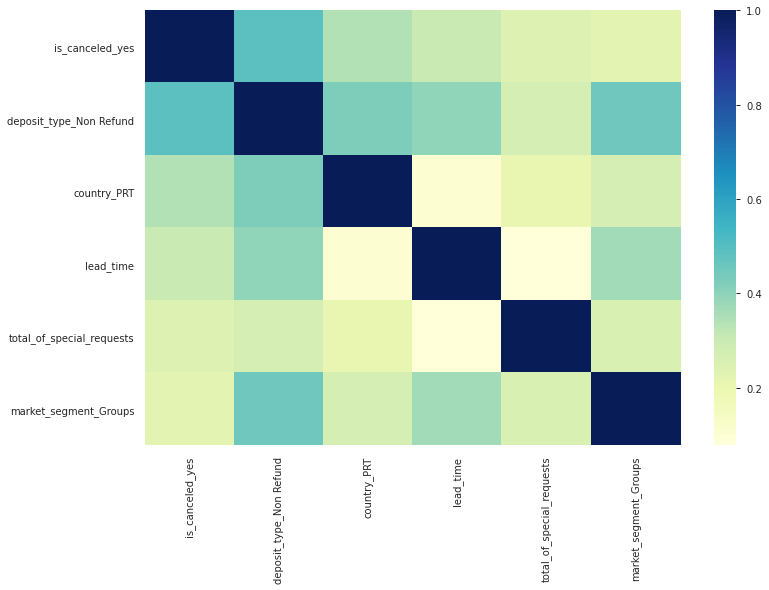

In [20]:
df = np.abs(data_final_r.corr())
new_index = df['is_canceled_yes'].sort_values(ascending=False, key=abs).index
df = df.reindex(new_index)
df = df.reindex(new_index, axis=1)

plt.figure(figsize=(12,8))
sns.heatmap(df, cmap="YlGnBu")
plt.show()

Repetimos considerando la estadística MIC que mide si hay una relación funcional entre las variables

In [21]:
col_pairs=list(itertools.combinations(data_final.columns, 2))

df_res = pd.DataFrame()
for a,b in col_pairs:
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(data_final[a], data_final[b])
    df_res=df_res.append({"v1":a, "v2":b, "mic":mine.mic()}, ignore_index=True)

Nos fijamos los casos que corresponden a correlaciones con la variable "is_canceled"

In [22]:
mics = df_res[df_res["v1"]=="is_canceled_yes"].sort_values(by="mic", ascending=False).head(10)
mics

,mic,v1,v2
2465,0.191907,is_canceled_yes,deposit_type_Non Refund
2420,0.086305,is_canceled_yes,country_PRT
2442,0.035040,is_canceled_yes,market_segment_Groups
2447,0.025137,is_canceled_yes,distribution_channel_TA/TO
2445,0.019021,is_canceled_yes,distribution_channel_Direct
2441,0.018365,is_canceled_yes,market_segment_Direct
2389,0.014021,is_canceled_yes,country_FRA
2469,0.013863,is_canceled_yes,customer_type_Transient-Party
2468,0.013725,is_canceled_yes,customer_type_Transient
2458,0.012780,is_canceled_yes,assigned_room_type_D


Vemos que no hay indicios de relaciones funcionales entre las variables y la variable a predecir. La que tiene mayor índice MIC es la variable "deposit_type_Non Refund" (19%).

Graficamos las variables obtenidas en función de la variable a predecir utilizando un análisis bivariado. Analizamos primero el estado de los datos.

In [23]:
status(data_final_r)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,is_canceled_yes,0,0.0,1901,0.633667,2,uint8
1,deposit_type_Non Refund,0,0.0,2634,0.878000,2,uint8
2,country_PRT,0,0.0,1744,0.581333,2,uint8
3,lead_time,0,0.0,147,0.049000,392,int64
4,total_of_special_requests,0,0.0,1754,0.584667,5,int64
5,market_segment_Groups,0,0.0,2524,0.841333,2,uint8


La variable 'lead_time' será la única que consideraremos numérica, al resto las trataremos como categorías.

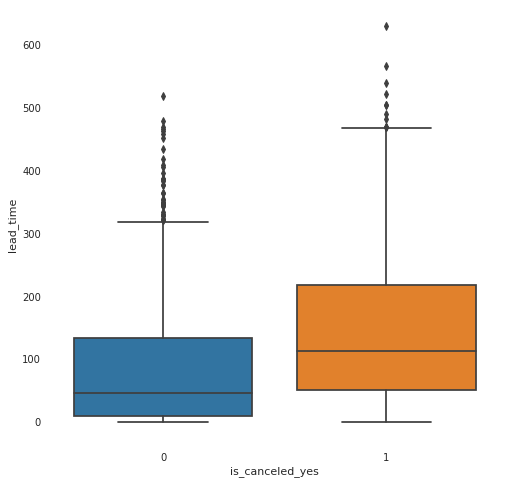

In [24]:
plt.figure(figsize=(8,8))
sns.boxplot(y = 'lead_time', x = 'is_canceled_yes', data = data_final_r)
plt.show()

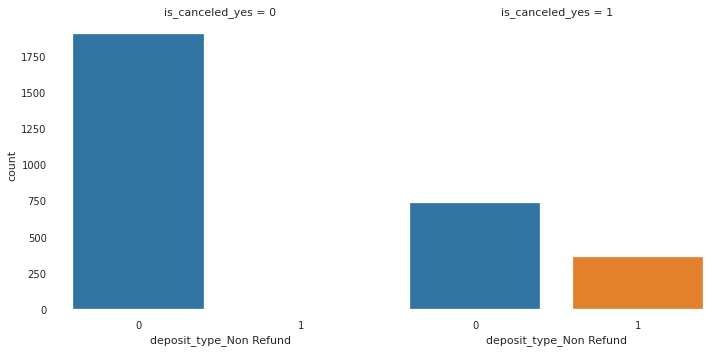

In [25]:
g = sns.catplot(x=variables[1],
                col="is_canceled_yes",
                data= data_final_r,
                kind="count")

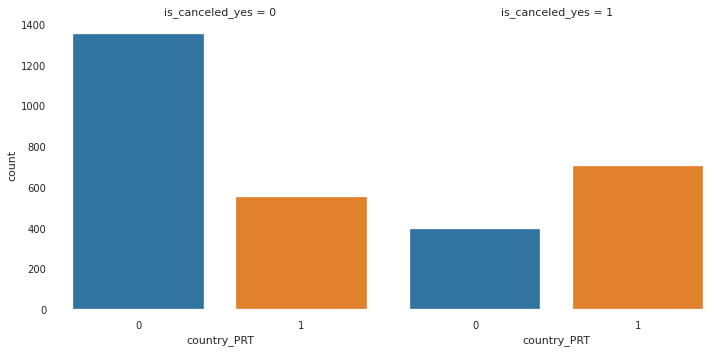

In [26]:
g = sns.catplot(x=variables[2],
                col="is_canceled_yes",
                data= data_final_r,
                kind="count")

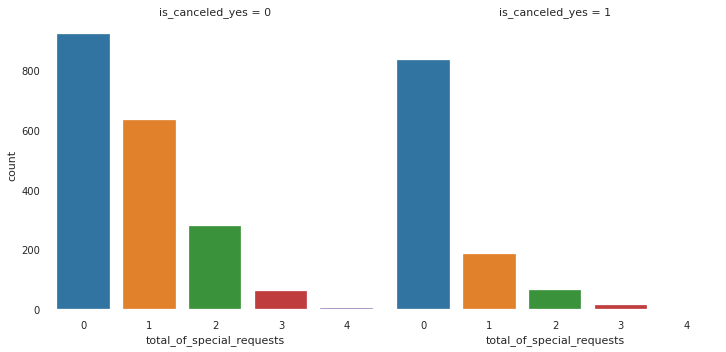

In [27]:
g = sns.catplot(x=variables[4],
                col="is_canceled_yes",
                data= data_final_r,
                kind="count")

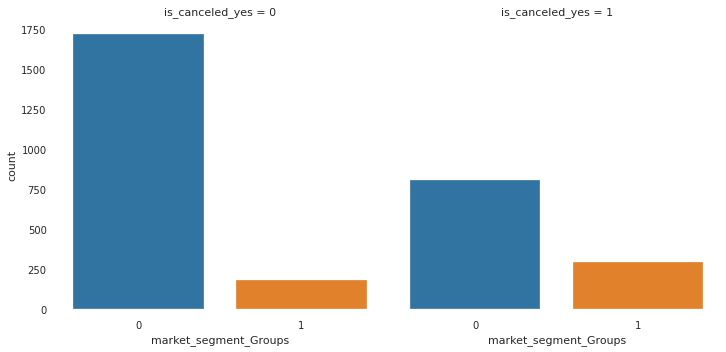

In [28]:
g = sns.catplot(x=variables[5],
                col="is_canceled_yes",
                data= data_final_r,
                kind="count")

A partir de los gráficos obtenidos podemos hacer conclusiones cualitativas:

- Las reservaciones son canceladas preferentemente cuando los tiempos entre la reserva y la llegada al hotel son mayores a 100 días.

- Las reservas no se cancelaron cuando los clientes pagaron un depósito del tipo no reembolsable. Las reservas canceladas fueron en su mayoría del tipo no reembolsable, pero hubo una significativa fracción que eran del tipo reembolsable. Parece que hay un efecto de desbalance de clases que debe ser analizado.

- Para clientes de Portugal las reservas en su mayoría fueron canceladas. Para clientes del exterior de Portugal en su mayoría las reservas no se cancelaron.

- Las cancelaciones en las reservas ocurrieron mayormente en casos en que los clientes no solicitaron requerimentos especiales. Cuando las reservas no se cancelaron, también la mayoría de clientes no solicitaron requerimentos especiales. En este caso es importante notar que las clases están desbalanceadas

- Se observa también que las reservas se cancelaron o no mayormente en para casos que la transacción se hizo por grupos. Sin embargo, también hay un problema de desbalance de clases por lo que debe hacerse un análisis cuantitativo.

Calculamos la cantidad de casos para cada una de las variables analizadas, para tener un valor del desbalance de clases,

In [29]:
data_final_r['lead_time'].value_counts()

0      147
1       78
2       56
3       56
4       43
      ... 
566      1
433      1
429      1
521      1
629      1
Name: lead_time, Length: 392, dtype: int64

In [30]:
data_final_r['deposit_type_Non Refund'].value_counts()

0    2634
1     366
Name: deposit_type_Non Refund, dtype: int64

In [31]:
data_final_r["country_PRT"].value_counts()

0    1744
1    1256
Name: country_PRT, dtype: int64

In [32]:
data_final_r["total_of_special_requests"].value_counts()

0    1754
1     822
2     342
3      75
4       7
Name: total_of_special_requests, dtype: int64

In [33]:
data_final_r["market_segment_Groups"].value_counts()

0    2524
1     476
Name: market_segment_Groups, dtype: int64

Hacemos un análisis cuantitativo para las variables que estamos tomando como categóricas con la función crosstab de pandas

In [34]:
pd.crosstab(data_final_r["deposit_type_Non Refund"], data_final_r["is_canceled_yes"], margins=True)

is_canceled_yes,0,1,All
deposit_type_Non Refund,,,
0,1899,735,2634
1,2,364,366
All,1901,1099,3000


In [35]:
pd.crosstab(data_final_r["deposit_type_Non Refund"], data_final_r["is_canceled_yes"], normalize="index", margins=True)

is_canceled_yes,0,1
deposit_type_Non Refund,,
0,0.720957,0.279043
1,0.005464,0.994536
All,0.633667,0.366333


Vemos que cuando los clientes pagaron el depósito reembolsable cancelaron la reserva en un 99% de los casos. Cuando el depósito pagado fue del tipo reembolsable la mayoría de clientes no cancelaron la reserva (72% de los casos).

In [36]:
pd.crosstab(data_final_r["country_PRT"], data_final_r["is_canceled_yes"], normalize="index", margins=True)

is_canceled_yes,0,1
country_PRT,,
0,0.774656,0.225344
1,0.437898,0.562102
All,0.633667,0.366333


Para clientes que no provienen de Portugal en su mayoría las reservas no fueron canceladas (77%). Para los casos de clientes que son de Portugal no hay una tendencia clara, aunque la mayoría canceló la reserva (56% de los casos).

In [37]:
pd.crosstab(data_final_r["total_of_special_requests"], data_final_r["is_canceled_yes"], normalize="index", margins=True)

is_canceled_yes,0,1
total_of_special_requests,,
0,0.525086,0.474914
1,0.772506,0.227494
2,0.812865,0.187135
3,0.813333,0.186667
4,0.857143,0.142857
All,0.633667,0.366333


Cuando los clientes pidieron requerimentos especiales las reservas en su gran mayoría no fueron canceladas (porcentajes mayores al 77% de los casos). Cuando no hubieron requerimentos especiales no hay una tendencia clara, aunque la mayoría tampoco fue cancelada (53% de los casos).

In [38]:
pd.crosstab(data_final_r["market_segment_Groups"], data_final_r["is_canceled_yes"], normalize="index", margins=True)

is_canceled_yes,0,1
market_segment_Groups,,
0,0.680666,0.319334
1,0.384454,0.615546
All,0.633667,0.366333


Cuando las transacciones no fueron hechas por grupos en general las reservas no se cancelaron (68% de los casos), mientras que cuando las transacciones fueron hechas por grupos se canceló la mayoría de ellas (62% de los casos).